In [1]:
# Import core PySpark modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, lag, avg, stddev, log, exp, sum as spark_sum
from pyspark.sql.window import Window

# Visualization and data conversion
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Start a Spark session
spark = SparkSession.builder.appName("FullScaleStockAnalytics").getOrCreate()

In [2]:
# Load CSV file into a Spark DataFrame
df = spark.read.csv("a.us.txt", header=True, inferSchema=True)

# Convert 'Date' column to proper date format and sort chronologically
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd")).orderBy("Date")

# Cache the DataFrame to optimize repeated access
df.cache()

# Show first few rows to verify structure
df.show(5)

+----------+------+------+------+------+--------+-------+
|      Date|  Open|  High|   Low| Close|  Volume|OpenInt|
+----------+------+------+------+------+--------+-------+
|1999-11-18|30.713|33.754|27.002|29.702|66277506|      0|
|1999-11-19|28.986|29.027|26.872|27.257|16142920|      0|
|1999-11-22|27.886|29.702|27.044|29.702| 6970266|      0|
|1999-11-23|28.688|29.446|27.002|27.002| 6332082|      0|
|1999-11-24|27.083|28.309|27.002|27.717| 5132147|      0|
+----------+------+------+------+------+--------+-------+
only showing top 5 rows


In [3]:
# Define a window specification ordered by date
windowSpec = Window.orderBy("Date")

In [4]:
# Calculate previous day's closing price
df = df.withColumn("PrevClose", lag("Close").over(windowSpec))

# Calculate daily return: (Close - PrevClose) / PrevClose
df = df.withColumn("DailyReturn", (col("Close") - col("PrevClose")) / col("PrevClose"))

# Calculate 21-day rolling volatility (standard deviation of daily returns)
df = df.withColumn("Volatility21", stddev("DailyReturn").over(windowSpec.rowsBetween(-20, 0)))

In [5]:
# 20-day moving average of closing price
df = df.withColumn("MA20", avg("Close").over(windowSpec.rowsBetween(-19, 0)))

# 50-day moving average of closing price
df = df.withColumn("MA50", avg("Close").over(windowSpec.rowsBetween(-49, 0)))

In [6]:
# Calculate log returns for compounding
df = df.withColumn("LogReturn", log(col("Close") / col("PrevClose")))

# Calculate cumulative return using exponential of summed log returns
df = df.withColumn("CumulativeReturn", exp(spark_sum("LogReturn").over(windowSpec)))

In [7]:
# Select relevant columns and convert to Pandas DataFrame
pdf = df.select("Date", "Close", "MA20", "MA50", "Volume", "DailyReturn", "Volatility21", "CumulativeReturn").toPandas()

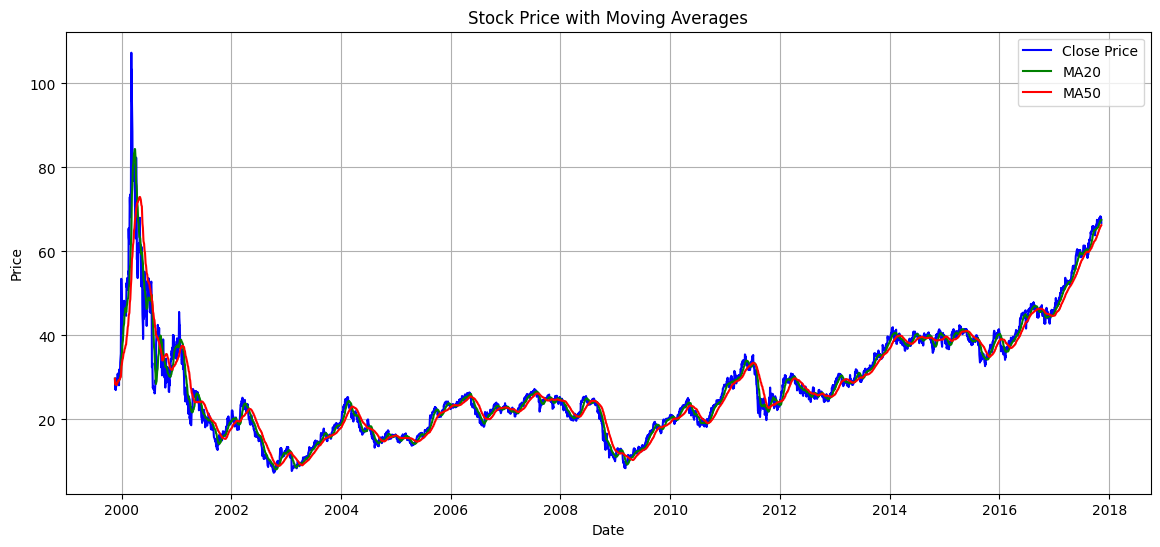

In [8]:
plt.figure(figsize=(14,6))
plt.plot(pdf['Date'], pdf['Close'], label='Close Price', color='blue')
plt.plot(pdf['Date'], pdf['MA20'], label='MA20', color='green')
plt.plot(pdf['Date'], pdf['MA50'], label='MA50', color='red')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

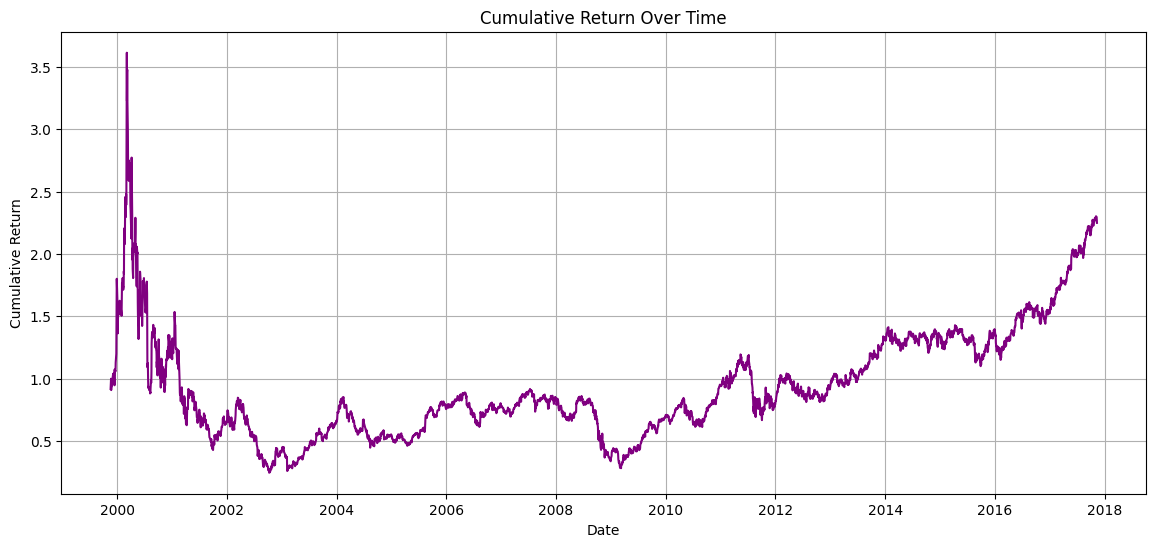

In [9]:
plt.figure(figsize=(14,6))
plt.plot(pdf['Date'], pdf['CumulativeReturn'], color='purple')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

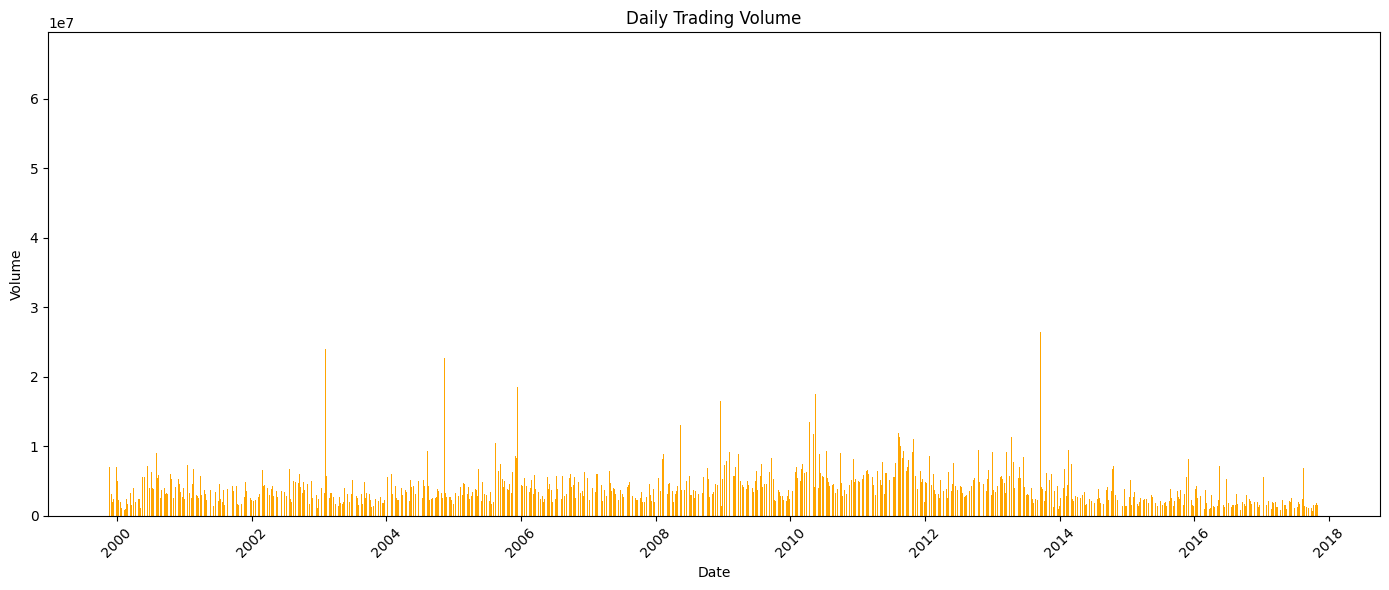

In [10]:
plt.figure(figsize=(14,6))
plt.bar(pdf['Date'], pdf['Volume'], color='orange')
plt.title('Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

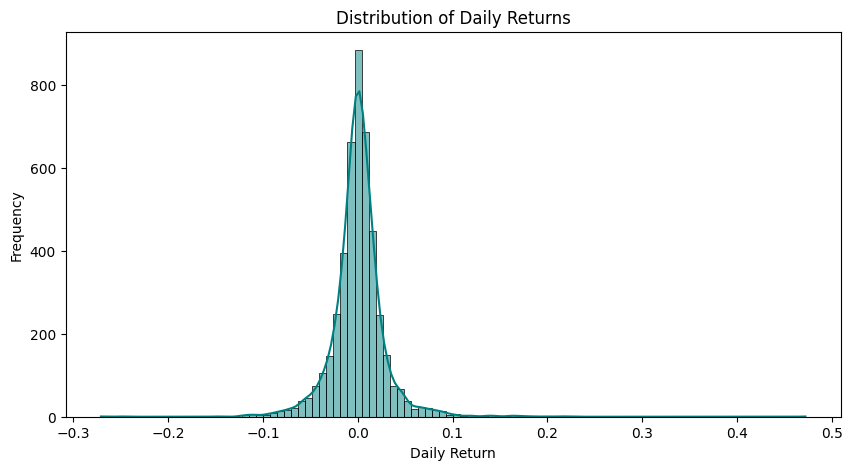

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(pdf['DailyReturn'].dropna(), bins=100, kde=True, color='teal')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

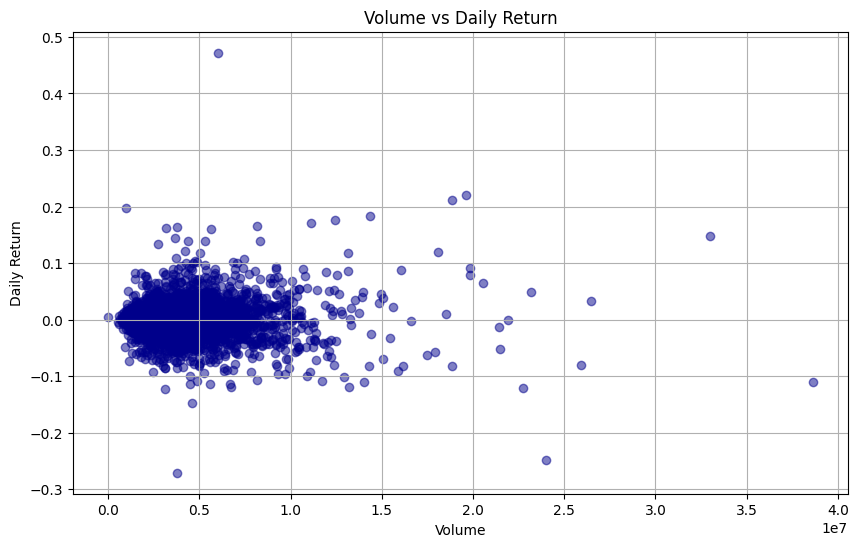

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(pdf['Volume'], pdf['DailyReturn'], alpha=0.5, color='darkblue')
plt.title('Volume vs Daily Return')
plt.xlabel('Volume')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

In [17]:
from pyspark.sql.functions import when, avg, col, lag

# Define window ordered by date
windowSpec = Window.orderBy("Date")

# --- 📈 RSI (Relative Strength Index) ---
# Step 1: Calculate daily price change
df = df.withColumn("PriceChange", col("Close") - lag("Close").over(windowSpec))

# Step 2: Separate gains and losses
df = df.withColumn("Gain", when(col("PriceChange") > 0, col("PriceChange")).otherwise(0))
df = df.withColumn("Loss", when(col("PriceChange") < 0, -col("PriceChange")).otherwise(0))

# Step 3: Compute 14-day average gain and loss
gain_avg = avg("Gain").over(windowSpec.rowsBetween(-13, 0))
loss_avg = avg("Loss").over(windowSpec.rowsBetween(-13, 0))
df = df.withColumn("AvgGain", gain_avg)
df = df.withColumn("AvgLoss", loss_avg)

# Step 4: Calculate RS and RSI
df = df.withColumn("RS", col("AvgGain") / col("AvgLoss"))
df = df.withColumn("RSI", when(col("AvgLoss") == 0, 100).otherwise(100 - (100 / (1 + col("RS")))))

# --- 📊 MACD (Moving Average Convergence Divergence) ---
# Step 1: Compute 12-day and 26-day moving averages (simple EMA approximation)
ema12 = avg("Close").over(windowSpec.rowsBetween(-11, 0))
ema26 = avg("Close").over(windowSpec.rowsBetween(-25, 0))
df = df.withColumn("EMA12", ema12)
df = df.withColumn("EMA26", ema26)

# Step 2: MACD = EMA12 - EMA26
df = df.withColumn("MACD", col("EMA12") - col("EMA26"))

# ✅ Preview results
df.select("Date", "Close", "RSI", "MACD").show(10)

+----------+------+------------------+----+
|      Date| Close|               RSI|MACD|
+----------+------+------------------+----+
|1999-11-18|29.702|             100.0| 0.0|
|1999-11-19|27.257|               0.0| 0.0|
|1999-11-22|29.702|              50.0| 0.0|
|1999-11-23|27.002| 32.21343873517786| 0.0|
|1999-11-24|27.717| 38.04936785069234| 0.0|
|1999-11-26|27.807| 38.71351995235258| 0.0|
|1999-11-29|28.432|42.960088691795995| 0.0|
|1999-11-30| 28.48| 43.26202029113365| 0.0|
|1999-12-01|28.986| 46.26070607896386| 0.0|
|1999-12-02|29.786| 50.40485829959515| 0.0|
+----------+------+------------------+----+
only showing top 10 rows


In [20]:
from pyspark.sql.functions import col, lag, stddev
from pyspark.sql.window import Window

windowSpec = Window.orderBy("Date")

df = df.withColumn("PrevClose", lag("Close").over(windowSpec))
df = df.withColumn("DailyReturn", (col("Close") - col("PrevClose")) / col("PrevClose"))
df = df.withColumn("Volatility21", stddev("DailyReturn").over(windowSpec.rowsBetween(-20, 0)))

df.select("Date", "Close", "PrevClose", "DailyReturn", "Volatility21").show(10)

+----------+------+---------+--------------------+--------------------+
|      Date| Close|PrevClose|         DailyReturn|        Volatility21|
+----------+------+---------+--------------------+--------------------+
|1999-11-18|29.702|     NULL|                NULL|                NULL|
|1999-11-19|27.257|   29.702| -0.0823176890445088|                NULL|
|1999-11-22|29.702|   27.257| 0.08970172799647798|  0.1216360962854385|
|1999-11-23|27.002|   29.702|-0.09090296949700366| 0.10188428373754947|
|1999-11-24|27.717|   27.002|0.026479520035552918| 0.08750951032516734|
|1999-11-26|27.807|   27.717|0.003247104665007...| 0.07618880829059049|
|1999-11-29|28.432|   27.807|0.022476354874671846|  0.0694829459164902|
|1999-11-30| 28.48|   28.432|0.001688238604389...| 0.06348267080495586|
|1999-12-01|28.986|    28.48|0.017766853932584276| 0.05928595744347701|
|1999-12-02|29.786|   28.986|0.027599530807976287|0.056297834637004475|
+----------+------+---------+--------------------+--------------

In [21]:
from pyspark.sql.functions import avg

df = df.withColumn("MA20", avg("Close").over(windowSpec.rowsBetween(-19, 0)))
df = df.withColumn("MA50", avg("Close").over(windowSpec.rowsBetween(-49, 0)))

df.select("Date", "Close", "MA20", "MA50").show(10)

+----------+------+------------------+------------------+
|      Date| Close|              MA20|              MA50|
+----------+------+------------------+------------------+
|1999-11-18|29.702|            29.702|            29.702|
|1999-11-19|27.257|           28.4795|           28.4795|
|1999-11-22|29.702|            28.887|            28.887|
|1999-11-23|27.002|          28.41575|          28.41575|
|1999-11-24|27.717|            28.276|            28.276|
|1999-11-26|27.807| 28.19783333333333| 28.19783333333333|
|1999-11-29|28.432| 28.23128571428571| 28.23128571428571|
|1999-11-30| 28.48|28.262374999999995|28.262374999999995|
|1999-12-01|28.986|28.342777777777773|28.342777777777773|
|1999-12-02|29.786|28.487099999999998|28.487099999999998|
+----------+------+------------------+------------------+
only showing top 10 rows


In [22]:
from pyspark.sql.functions import log, exp, sum as spark_sum

df = df.withColumn("LogReturn", log(col("Close") / col("PrevClose")))
df = df.withColumn("CumulativeReturn", exp(spark_sum("LogReturn").over(windowSpec)))

df.select("Date", "Close", "CumulativeReturn").show(10)

+----------+------+------------------+
|      Date| Close|  CumulativeReturn|
+----------+------+------------------+
|1999-11-18|29.702|              NULL|
|1999-11-19|27.257|0.9176823109554912|
|1999-11-22|29.702|               1.0|
|1999-11-23|27.002|0.9090970305029965|
|1999-11-24|27.717|0.9331694835364622|
|1999-11-26|27.807|0.9361995825196958|
|1999-11-29|28.432|0.9572419365699281|
|1999-11-30| 28.48| 0.958857989360986|
|1999-12-01|28.986|0.9758938792000541|
|1999-12-02|29.786|1.0028280923843516|
+----------+------+------------------+
only showing top 10 rows


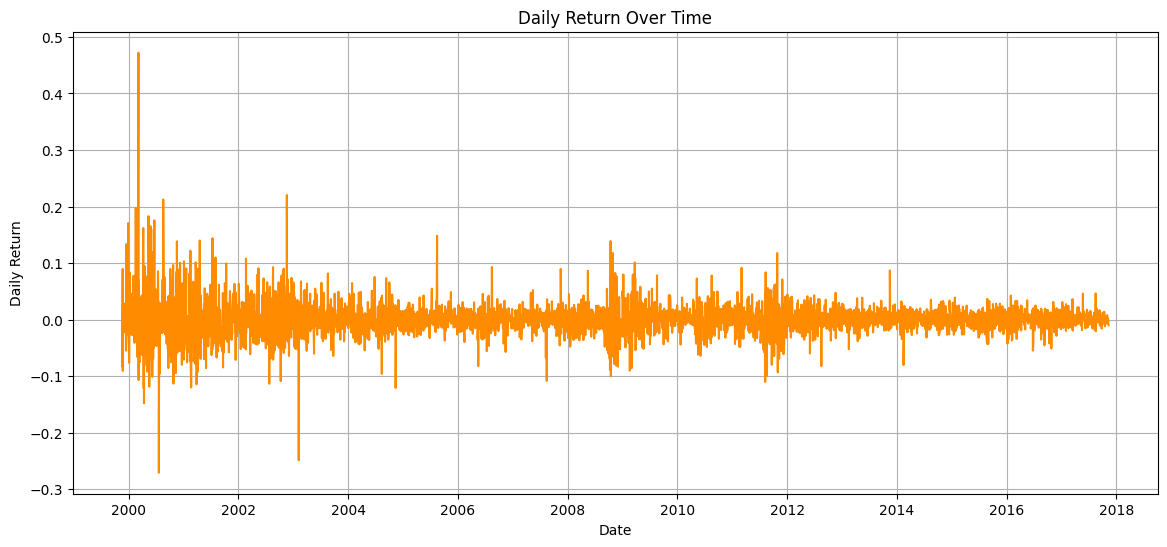

In [23]:
plt.figure(figsize=(14,6))
plt.plot(pdf['Date'], pdf['DailyReturn'], color='darkorange')
plt.title('Daily Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

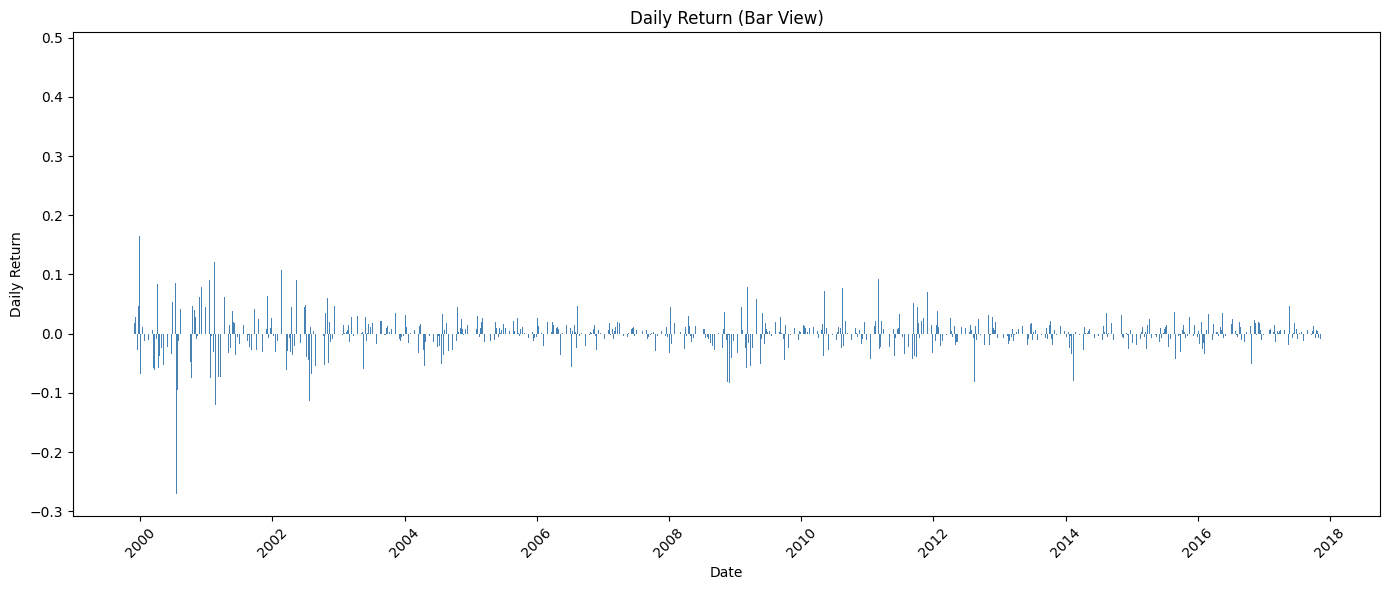

In [24]:
plt.figure(figsize=(14,6))
plt.bar(pdf['Date'], pdf['DailyReturn'], color='steelblue')
plt.title('Daily Return (Bar View)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

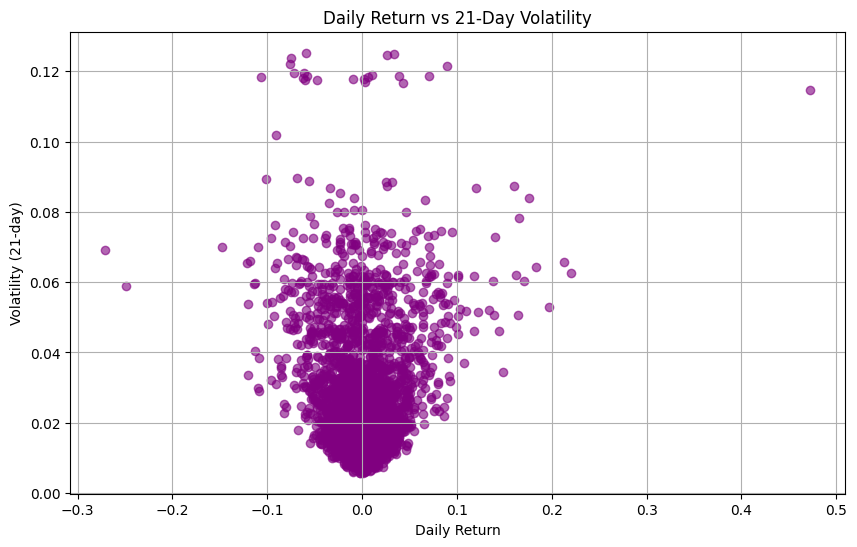

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(pdf['DailyReturn'], pdf['Volatility21'], alpha=0.6, color='purple')
plt.title('Daily Return vs 21-Day Volatility')
plt.xlabel('Daily Return')
plt.ylabel('Volatility (21-day)')
plt.grid(True)
plt.show()

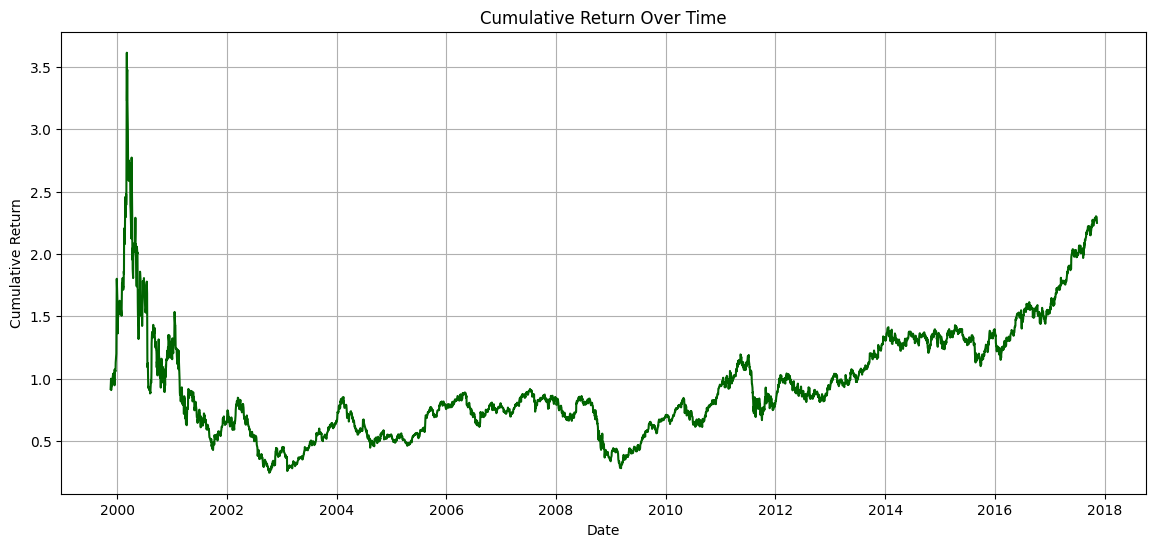

In [26]:
plt.figure(figsize=(14,6))
plt.plot(pdf['Date'], pdf['CumulativeReturn'], color='darkgreen')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()